In [3]:
import tensorflow as tf
print(tf.__version__)


2.18.0


In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import mixed_precision

# Charger le dataset Food-101 (train uniquement)
dataset, info = tfds.load("food101", split="train", as_supervised=True, with_info=True)

# Récupérer les noms des classes
class_names = info.features['label'].names

# Diviser en train/validation (80% - 20%)
train_split = 0.8
dataset_size = sum(1 for _ in dataset)
train_size = int(train_split * dataset_size)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

# Fonction de prétraitement des images
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0  # Normalisation [0,1]
    return image, label

# Appliquer prétraitement
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Batch et préfetch des données
batch_size = 64
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Activer l'entraînement en précision mixte
mixed_precision.set_global_policy('mixed_float16')

In [10]:
# Cnn model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), strides=1, padding='same', activation='relu', input_shape=(224, 224, 3), kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (5, 5), strides=2, padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(128, (2, 2), padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (2, 2), padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(256, (2, 2), padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (2, 2), padding='same', activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(512, activation="relu", kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(len(class_names), activation="softmax", dtype='float32')  # dtype='float32' pour éviter erreurs Mixed Precision
])

In [11]:
# model compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [12]:
# Display the model structure
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 224, 224, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 112, 112, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 28, 28, 128)         │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 28, 28, 128)         │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 765,061 (2.92 MB)

 Trainable params: 762,117 (2.91 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [13]:
# Callbacks to get a better training
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training of the model
# Entraînement du modèle
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=45,
    callbacks=[lr_scheduler, early_stopping]
)
model.save("cnn_food101_10classes__v2.h5")

print("✅ Modèle sauvegardé avec succès sous 'cnn_food101_10classes.h5'")

Epoch 1/45
947/947 ━━━━━━━━━━━━━━━━━━━━ 79s 65ms/step - accuracy: 0.0535 - loss: 4.5503 - val_accuracy: 0.1253 - val_loss: 3.8789 - learning_rate: 0.0010
Epoch 2/45
947/947 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.1746 - loss: 3.5562 - val_accuracy: 0.2332 - val_loss: 3.3194 - learning_rate: 0.0010
Epoch 3/45
947/947 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.2830 - loss: 2.9613 - val_accuracy: 0.3050 - val_loss: 2.9915 - learning_rate: 0.0010
Epoch 4/45
947/947 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.3643 - loss: 2.5690 - val_accuracy: 0.3894 - val_loss: 2.4818 - learning_rate: 0.0010
Epoch 5/45
947/947 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.4246 - loss: 2.2895 - val_accuracy: 0.4065 - val_loss: 2.4337 - learning_rate: 0.0010
Epoch 6/45
947/947 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.4686 - loss: 2.0916 - val_accuracy: 0.4298 - val_loss: 2.3903 - learning_rate: 0.0010
Epoch 7/45
947/947 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.5076 - l

✅ Modèle sauvegardé avec succès sous 'cnn_food101_10classes.h5'


In [14]:
# Evaluate the model on the validation dataset
test_loss, test_acc = model.evaluate(val_ds)
print(f'\nValidation Accuracy: {test_acc * 100:.2f}%')
print(f'\nValidation Loss: {test_loss:.4f}')

237/237 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.5653 - loss: 2.1230

Validation Accuracy: 55.66%

Validation Loss: 2.1705


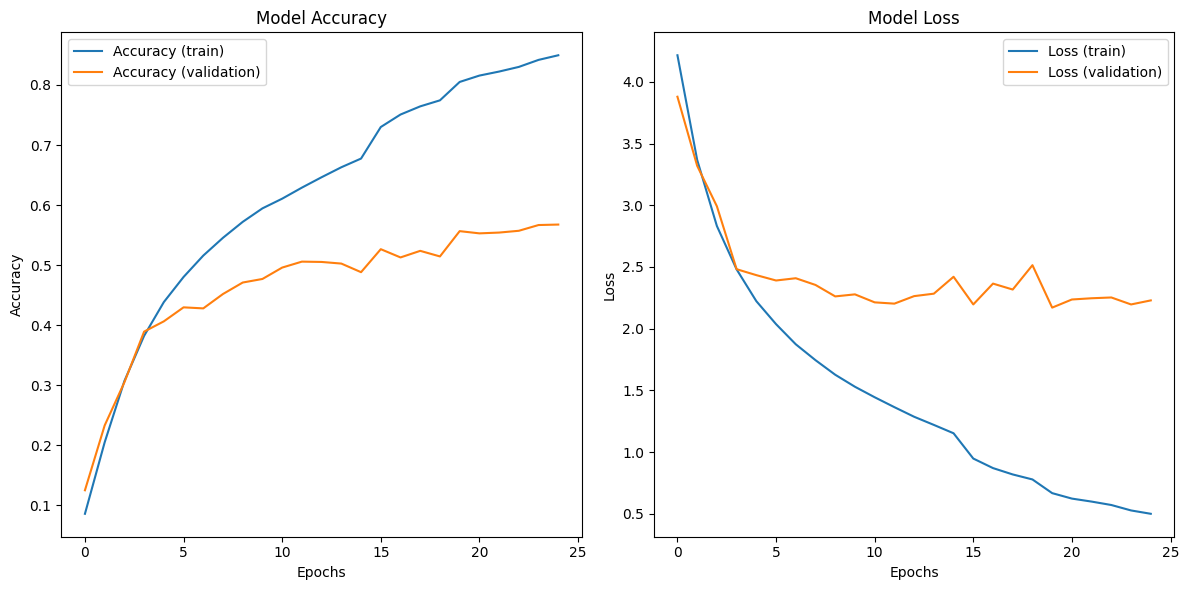

In [15]:
import matplotlib.pyplot as plt
# Plots of loss and accuracy
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.figure(figsize=(12, 6))

# Accuracy graph
plt.subplot(1, 2, 1)
plt.plot(acc, label='Accuracy (train)')
plt.plot(val_acc, label='Accuracy (validation)')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss graph
plt.subplot(1, 2, 2)
plt.plot(loss, label='Loss (train)')
plt.plot(val_loss, label='Loss (validation)')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Classification report
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in val_ds], axis=0)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

237/237 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step
Classification Report:
                         precision    recall  f1-score   support

              apple_pie     0.2824    0.3179    0.2991       151
         baby_back_ribs     0.4398    0.5489    0.4883       133
                baklava     0.7009    0.6074    0.6508       135
         beef_carpaccio     0.6906    0.6275    0.6575       153
           beef_tartare     0.4429    0.6078    0.5124       153
             beet_salad     0.6018    0.4857    0.5375       140
               beignets     0.6842    0.7738    0.7263       168
               bibimbap     0.7358    0.7267    0.7312       161
          bread_pudding     0.2889    0.3688    0.3240       141
      breakfast_burrito     0.4945    0.3285    0.3947       137
             bruschetta     0.5029    0.5906    0.5432       149
           caesar_salad     0.6038    0.6000    0.6019       160
                cannoli     0.6829    0.5350    0.6000       157
          caprese_salad

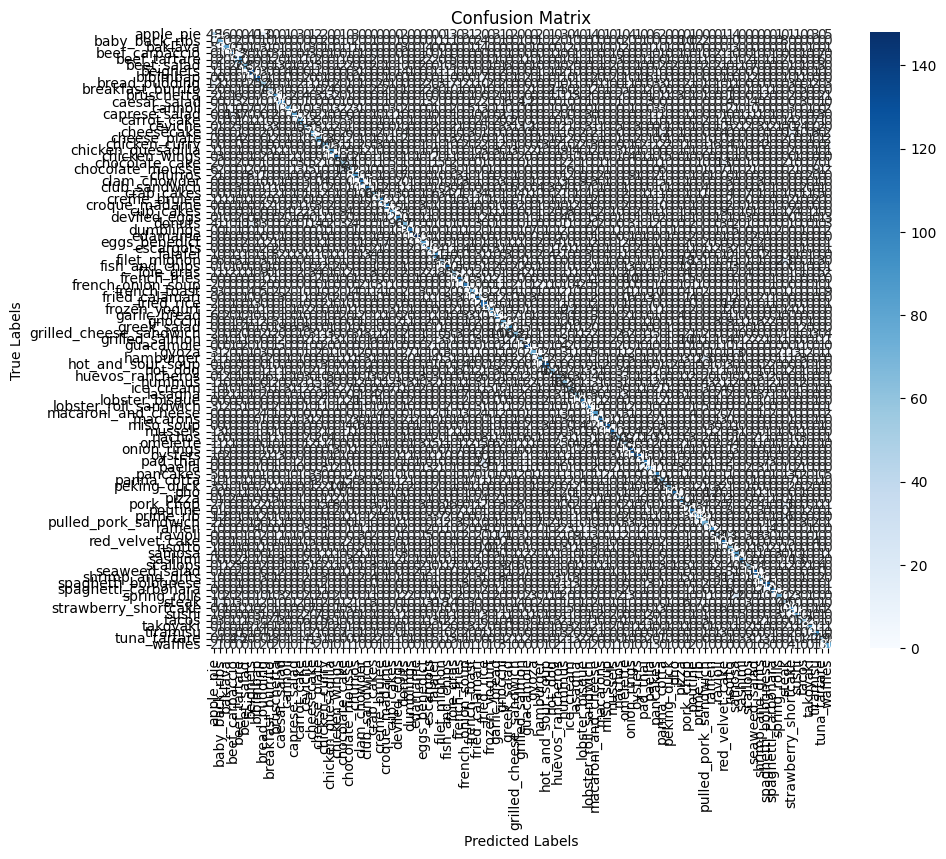

In [17]:
#confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [18]:
import pandas as pd

# Générer le rapport de classification sous forme de dictionnaire
report_dict = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)

# Convertir en DataFrame
df = pd.DataFrame(report_dict).transpose()

# Sauvegarder au format CSV
df.to_csv("classification_report.csv", index=True)

print("done under 'classification_report.csv'")


done under 'classification_report.csv'
